<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#extra-one-hot-features" data-toc-modified-id="extra-one-hot-features-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>extra one-hot features</a></span></li><li><span><a href="#extra-keywords" data-toc-modified-id="extra-keywords-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>extra keywords</a></span></li></ul></li><li><span><a href="#Dense" data-toc-modified-id="Dense-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dense</a></span></li></ul></div>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TextCNN" data-toc-modified-id="TextCNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TextCNN</a></span><ul class="toc-item"><li><span><a href="#notes:" data-toc-modified-id="notes:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>notes:</a></span></li></ul></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LSTM</a></span></li></ul></div>

In [130]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/Text-Classification/code")
!pip install pyLDAvis
!pip install gensim
!pip install pandas==1.3.0

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [131]:
from classification_utils import *
from clustering_utils import *
from eda_utils import *
from nn_utils_keras import *
from feature_engineering_utils import *
from data_utils import *

In [133]:
train, test = load_data(only_stem_voc=True)
# train, test = load_data(sample50=True)
#  train, upsampling_info = upsampling_train(train)

train_text, train_label = train_augmentation(train, select_comb=[['reply', 'reference_one']])
test_text, test_label = test['reply'], test['label']

# test_text = test_text.apply(lambda x: extract_stem_voc(x))
# train_text = train_text.apply(lambda x: extract_stem_voc(x))
# train_text.to_csv("stem_voc_train.csv")
# test_text.to_csv("stem_voc_test.csv")

# train_text, test_text = load_stem_voc()


may use cols: 
 ['global_index', 'doc_path', 'label', 'reply', 'reference_one', 'reference_two', 'tag_reply', 'tag_reference_one', 'tag_reference_two', 'Subject', 'From', 'Lines', 'Organization', 'contained_emails', 'long_string', 'text', 'error_message']
combination 1 train:  ['reply', 'reference_one']


In [134]:
####################################
### label mapper
####################################
labels = sorted(train_label.unique())
label_mapper = dict(zip(labels, range(len(labels))))
train_label = train_label.map(label_mapper)
test_label = test_label.map(label_mapper)
y_train = train_label
y_test = test_label

print(train_text.shape)
print(test_text.shape)
print(train_label.shape)
print(test_label.shape)
print(labels)

(11083,)
(7761,)
(11083,)
(7761,)
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


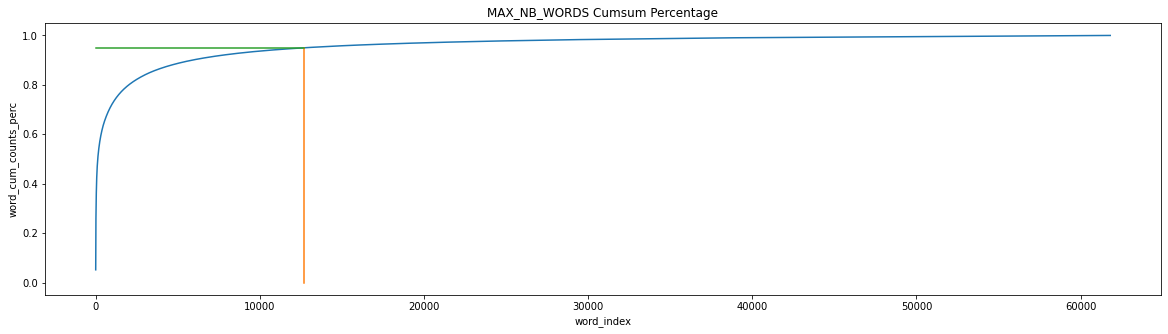

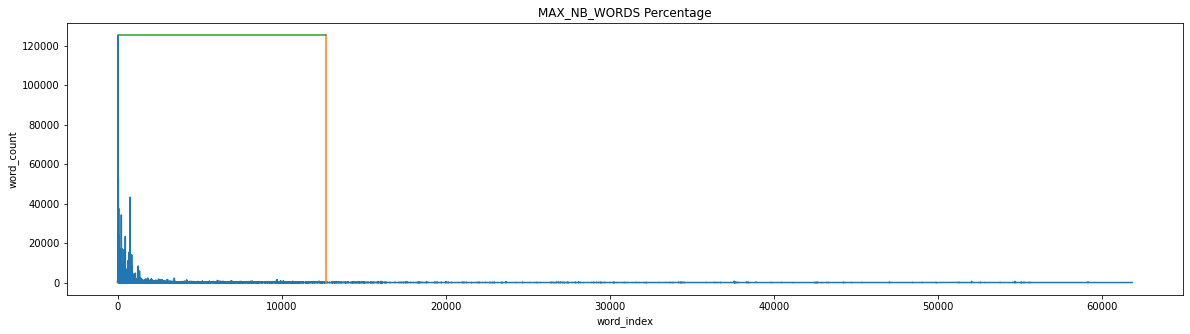

Cut index with 95.0 % of corpus:  12682 

    index  word   count
0      28   the  125249
1      32    to   63429
2      11    of   56440
3      45     a   53640
4      22   and   49720
5     761     i   43242
6      64    is   37583
7      29    in   36585
8     228  that   34262
9      43    it   29096
10     82   for   23405
11    471   you   23355
12    246  this   17446
13     51    on   16876
14    394    be   16689
15     26   are   16277
16     44     s   15976
17    762  have   15769
18    701   not   15379
19     55  with   14870


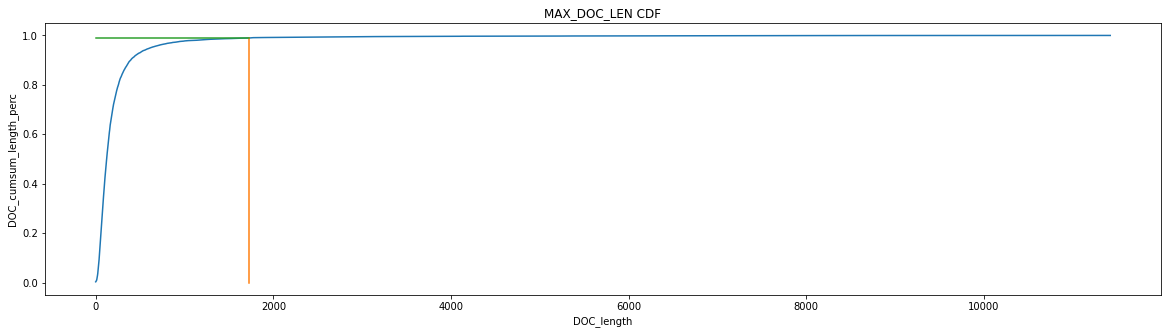

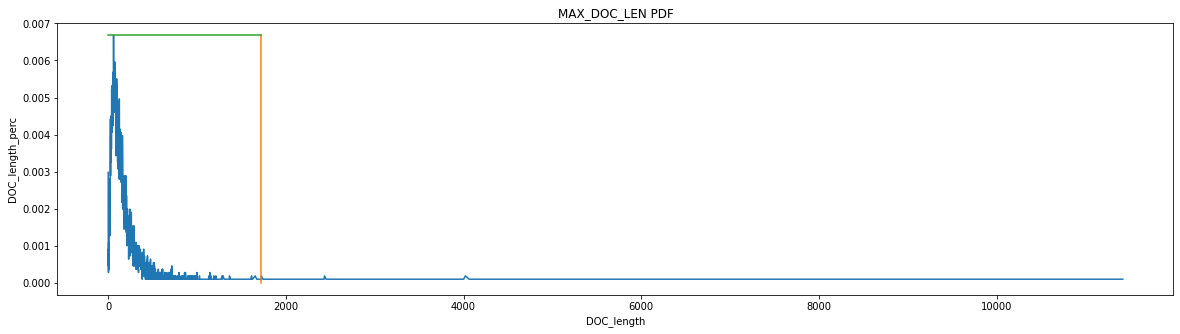

Cut index with 99.0 % of corpus:  1725


In [135]:
####################################
### hyper params 
####################################
filters = '"#$%&()*+,-/:;<=>@[\\]^_`{|}~\t\n0123465789!.?\''
MAX_NB_WORDS_ratio = 0.95
MAX_DOC_LEN_ratio = 0.99
MAX_NB_WORDS = eda_MAX_NB_WORDS(train_text, ratio=MAX_NB_WORDS_ratio, char_level=False, filters=filters)
MAX_DOC_LEN = eda_MAX_DOC_LEN(train_text, ratio=MAX_DOC_LEN_ratio, char_level=False, filters=filters)

In [136]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

## extra one-hot features

In [137]:
# one_hot_X_train, one_hot_X_test, one_hot_word_to_idx, one_hot_count_vect = count_vectorizer(
#     train['Subject']+" " + train['Organization'], test['Subject']+" " + test['Organization'], stop_words=True, binary=False, min_df=3, max_df=0.001)

## extra keywords

In [138]:
# label_docs = train.groupby('label')['text'].apply(lambda x: " ".join(x)) # 要去除标点符号
# dtm, _, label_word_to_idx, _ = count_vectorizer(label_docs, [''], stop_words=True, min_df=1, binary=True)
# label_idx_to_word = dict([val, key] for key, val in label_word_to_idx.items())
# keywords_threshold = 1
# keywords_idx = np.where(dtm.sum(axis=0)<=keywords_threshold)[0]
# print(" keywords_idx shape: ")
# voc = [label_idx_to_word[idx] for idx in keywords_idx]

# keywords_X_train, keywords_X_test, keywords_word_to_idx, keywords_count_vect = count_vectorizer(
#     train['text'], test['text'], voc=voc, stop_words=True, min_df=1, binary=True)

# Dense

In [139]:
X_train, X_test, word_to_idx, tfidf_vect = tfidf_vectorizer(train_text, test_text, stop_words=True, binary=True, min_df=5, ngram_range=(2,3))
X_train, transform_mapper = dimension_reduction(X_train, out_dim=500) # not allow negative 
X_test = transform_mapper.transform(X_test)

num of words: 32331
Dimension reduction with truncate SVD:
   input columns with  32331
   output columns with  500


/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.7/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

In [140]:
# stop

# del X_train
# del X_test


In [141]:
_X_train = np.hstack([X_train])
_X_test = np.hstack([X_test])
# _X_train = np.hstack([X_train, keywords_X_train])
# _X_test = np.hstack([X_test, keywords_X_test])

# _X_train = np.hstack([X_train, one_hot_X_train, keywords_X_train])
# _X_test = np.hstack([X_test, one_hot_X_test, keywords_X_test])

In [142]:
opt = optimizers.Adam(learning_rate=0.005)

model = Sequential()
model.add(Input(shape=_X_train.shape[1],))  # input cannot connect with dropout directly
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(20, activation='softmax'))
model.compile(optimizer=opt,
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])


# model.compile(optimizer=opt,
#                 loss=keras.losses.CategoricalHinge(),
#               metrics=[keras.metrics.CategoricalAccuracy()])

In [143]:
BATCH_SIZE = 64 # 16 # 先在小的batch上train, 容易找到全局最优部分, 然后再到 大 batch 上train, 快速收敛到局部最优
NUM_EPOCHES = 100  # 20步以上
patience = 80

file_name = 'test'
BestModel_Name = file_name + 'Best_GS_6'
BEST_MODEL_FILEPATH = BestModel_Name
earlyStopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
# history = model.fit(_X_train, y_train, validation_data=(_X_test,y_test), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)

history = model.fit(_X_train, y_train, validation_data=(_X_test,y_test), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=None, verbose=1)
# history = model.fit(_X_train, to_categorical(y_train), validation_data=(_X_test,to_categorical(y_test)), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=None, verbose=1)
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=1)

Epoch 1/100
174/174 [==============================] - 1s 5ms/step - loss: 2.6438 - sparse_categorical_accuracy: 0.2849 - val_loss: 2.5139 - val_sparse_categorical_accuracy: 0.3484
Epoch 2/100
174/174 [==============================] - 1s 4ms/step - loss: 1.8082 - sparse_categorical_accuracy: 0.5154 - val_loss: 2.1566 - val_sparse_categorical_accuracy: 0.3927
Epoch 3/100
174/174 [==============================] - 1s 4ms/step - loss: 1.5056 - sparse_categorical_accuracy: 0.5712 - val_loss: 2.0570 - val_sparse_categorical_accuracy: 0.4124
Epoch 4/100
174/174 [==============================] - 1s 4ms/step - loss: 1.3876 - sparse_categorical_accuracy: 0.6008 - val_loss: 2.0074 - val_sparse_categorical_accuracy: 0.4190
Epoch 5/100
174/174 [==============================] - 1s 4ms/step - loss: 1.3121 - sparse_categorical_accuracy: 0.6191 - val_loss: 1.9909 - val_sparse_categorical_accuracy: 0.4217
Epoch 6/100
174/174 [==============================] - 1s 4ms/step - loss: 1.2672 - sparse_cate

loss val_loss


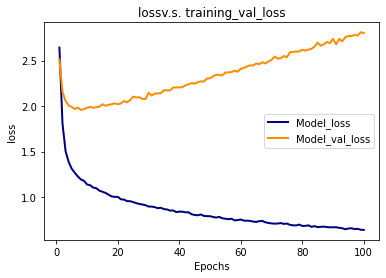

sparse_categorical_accuracy val_sparse_categorical_accuracy


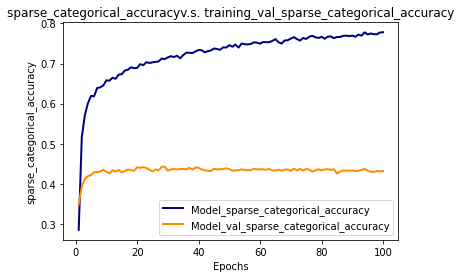

classification_report:
f1:  {'micro avg': 0.4316454065197784, 'macro avg': 0.4309778760408479} 

                          precision  recall  f1-score  support
alt.atheism                   0.355   0.320     0.337    319.0
comp.graphics                 0.356   0.373     0.364    389.0
comp.os.ms-windows.misc       0.543   0.381     0.448    394.0
comp.sys.ibm.pc.hardware      0.403   0.413     0.408    392.0
comp.sys.mac.hardware         0.431   0.379     0.403    385.0
comp.windows.x                0.476   0.524     0.499    395.0
misc.forsale                  0.596   0.674     0.633    390.0
rec.autos                     0.314   0.322     0.318    395.0
rec.motorcycles               0.477   0.535     0.504    398.0
rec.sport.baseball            0.246   0.592     0.348    397.0
rec.sport.hockey              0.909   0.229     0.365    827.0
sci.crypt                     0.682   0.578     0.626    396.0
sci.electronics               0.248   0.257     0.252    393.0
sci.med              

In [144]:
#### classification Report
history_plot(history)
y_pred = model.predict(_X_test)
classification_report = evaluation_report(y_test, np.argmax(y_pred, axis=1), labels=labels)

scores = model.evaluate(_X_test, y_test, verbose=2)
roc_auc(y_test, y_pred)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")